In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess

In [234]:
# Run the data generation script
subprocess.run(["pip", "install", "-r", "requirements.txt"])
subprocess.run(["g++", "-o", "fourier", "fourier.cpp", "-lm"])
subprocess.run(["./fourier"])

CompletedProcess(args=['./fourier'], returncode=0)

In [235]:
csv_file = []
for file in os.listdir():
    if file.endswith(".csv"):
        csv_file.append(file)
        print(file)


trajectory_position.csv
PID1.csv
inverted_trajectory_component.csv
alternative_kalman2.csv
luenberger2.csv
alternative_kalman1.csv
inverted_trajectory_position.csv
kalman2.csv
extended_kalman1.csv
trajectory_component.csv
kalman1.csv
PID2.csv
luenberger1.csv
extended_kalman2.csv
LQR1.csv
LQR2.csv


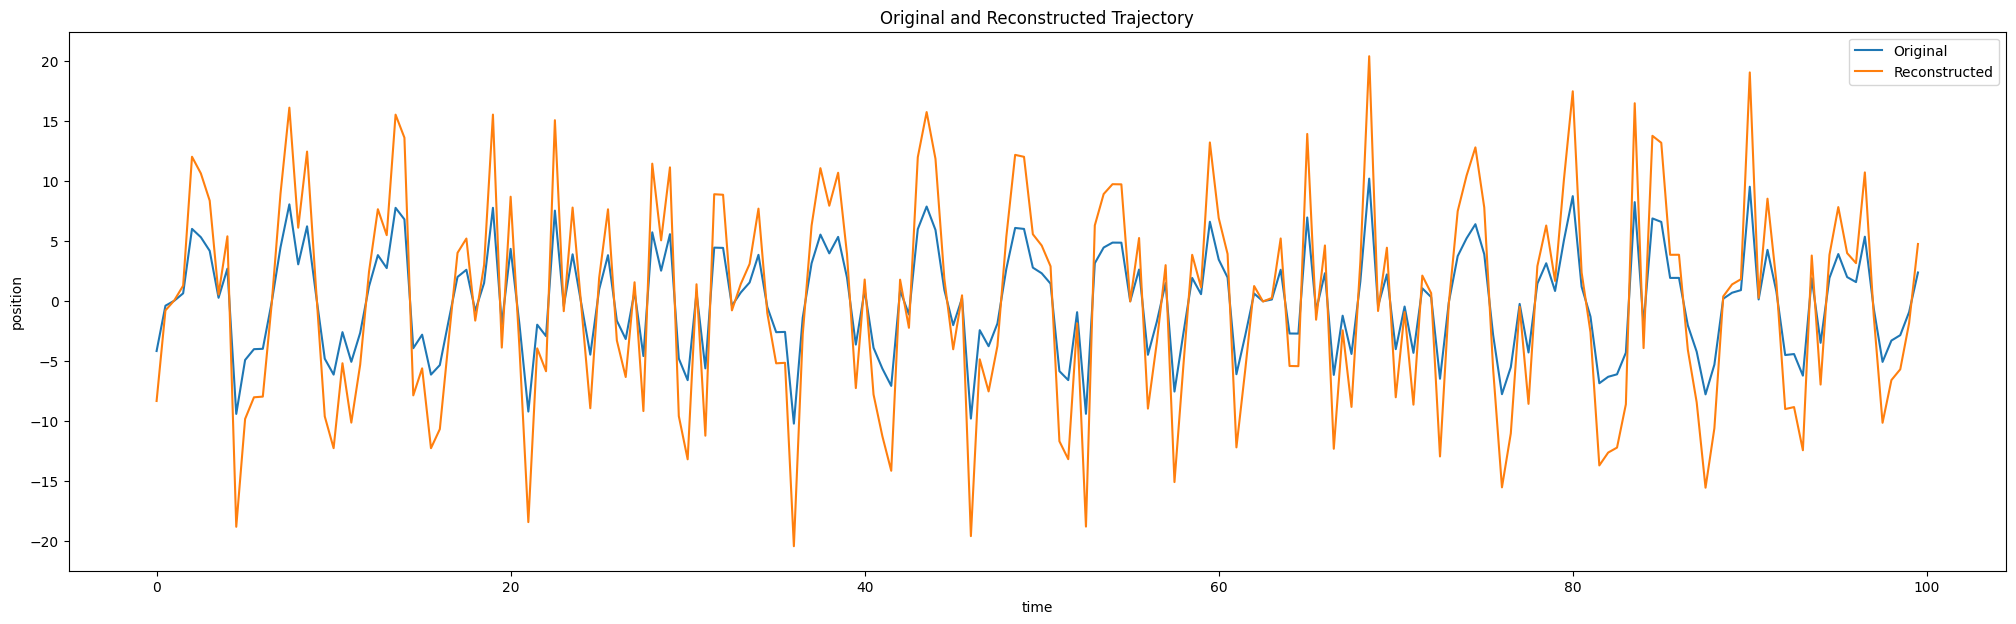

In [236]:
trajectory = pd.read_csv("trajectory_position.csv")
inverted_trajectory = pd.read_csv("inverted_trajectory_position.csv")

# plot in a figure size x=25, y=7
fig = plt.figure(figsize=(25, 7))
plt.plot(trajectory["time"], trajectory["position"])
plt.plot(inverted_trajectory["time"], inverted_trajectory["position"])
plt.xlabel("time")
plt.ylabel("position")
plt.title("Original and Reconstructed Trajectory")
plt.legend(["Original", "Reconstructed"])
plt.show()

In [237]:
# Combine trajectory and inverted trajectory dataframes with unique headers
trajectory_component = pd.read_csv("trajectory_component.csv")
inverted_trajectory_component = pd.read_csv("inverted_trajectory_component.csv")

# convert to table
trajectory_component = trajectory_component.pivot_table(index="n", values=["angular_velocity", "amplitude", "phase"])
inverted_trajectory_component = inverted_trajectory_component.pivot_table(index="n", values=["angular_velocity", "amplitude", "phase"])

trajectory_component

amplitude  angular_velocity    phase
n                                      
0   1.002750          -7.80764  5.20474
1   1.634360          -7.60304  6.56341
2   0.765446          -7.25309  1.06644
3   1.235550           7.09182  3.53291
4   2.128210           8.77362  8.20032
5   1.402070          -6.79821  8.33165
6   1.683810           2.04987  4.17013
7   2.232700          -1.05992  1.97108
8   3.962030           1.22456  3.09273
9   1.654180           2.19979  6.46076

In [238]:
inverted_trajectory_component

amplitude  angular_velocity     phase
n                                       
0   0.004388          0.000000  3.141590
1   0.072138          0.062832 -2.502440
2   0.051394          0.125664 -1.240420
3   0.094734          0.188496 -1.609280
4   0.072999          0.251327 -0.719598
5   0.098071          0.314159 -1.150090
6   0.050976          0.376991 -0.472337
7   0.087245          0.439823 -1.200220
8   0.044338          0.502655 -1.743200
9   0.126583          0.565487 -1.509160

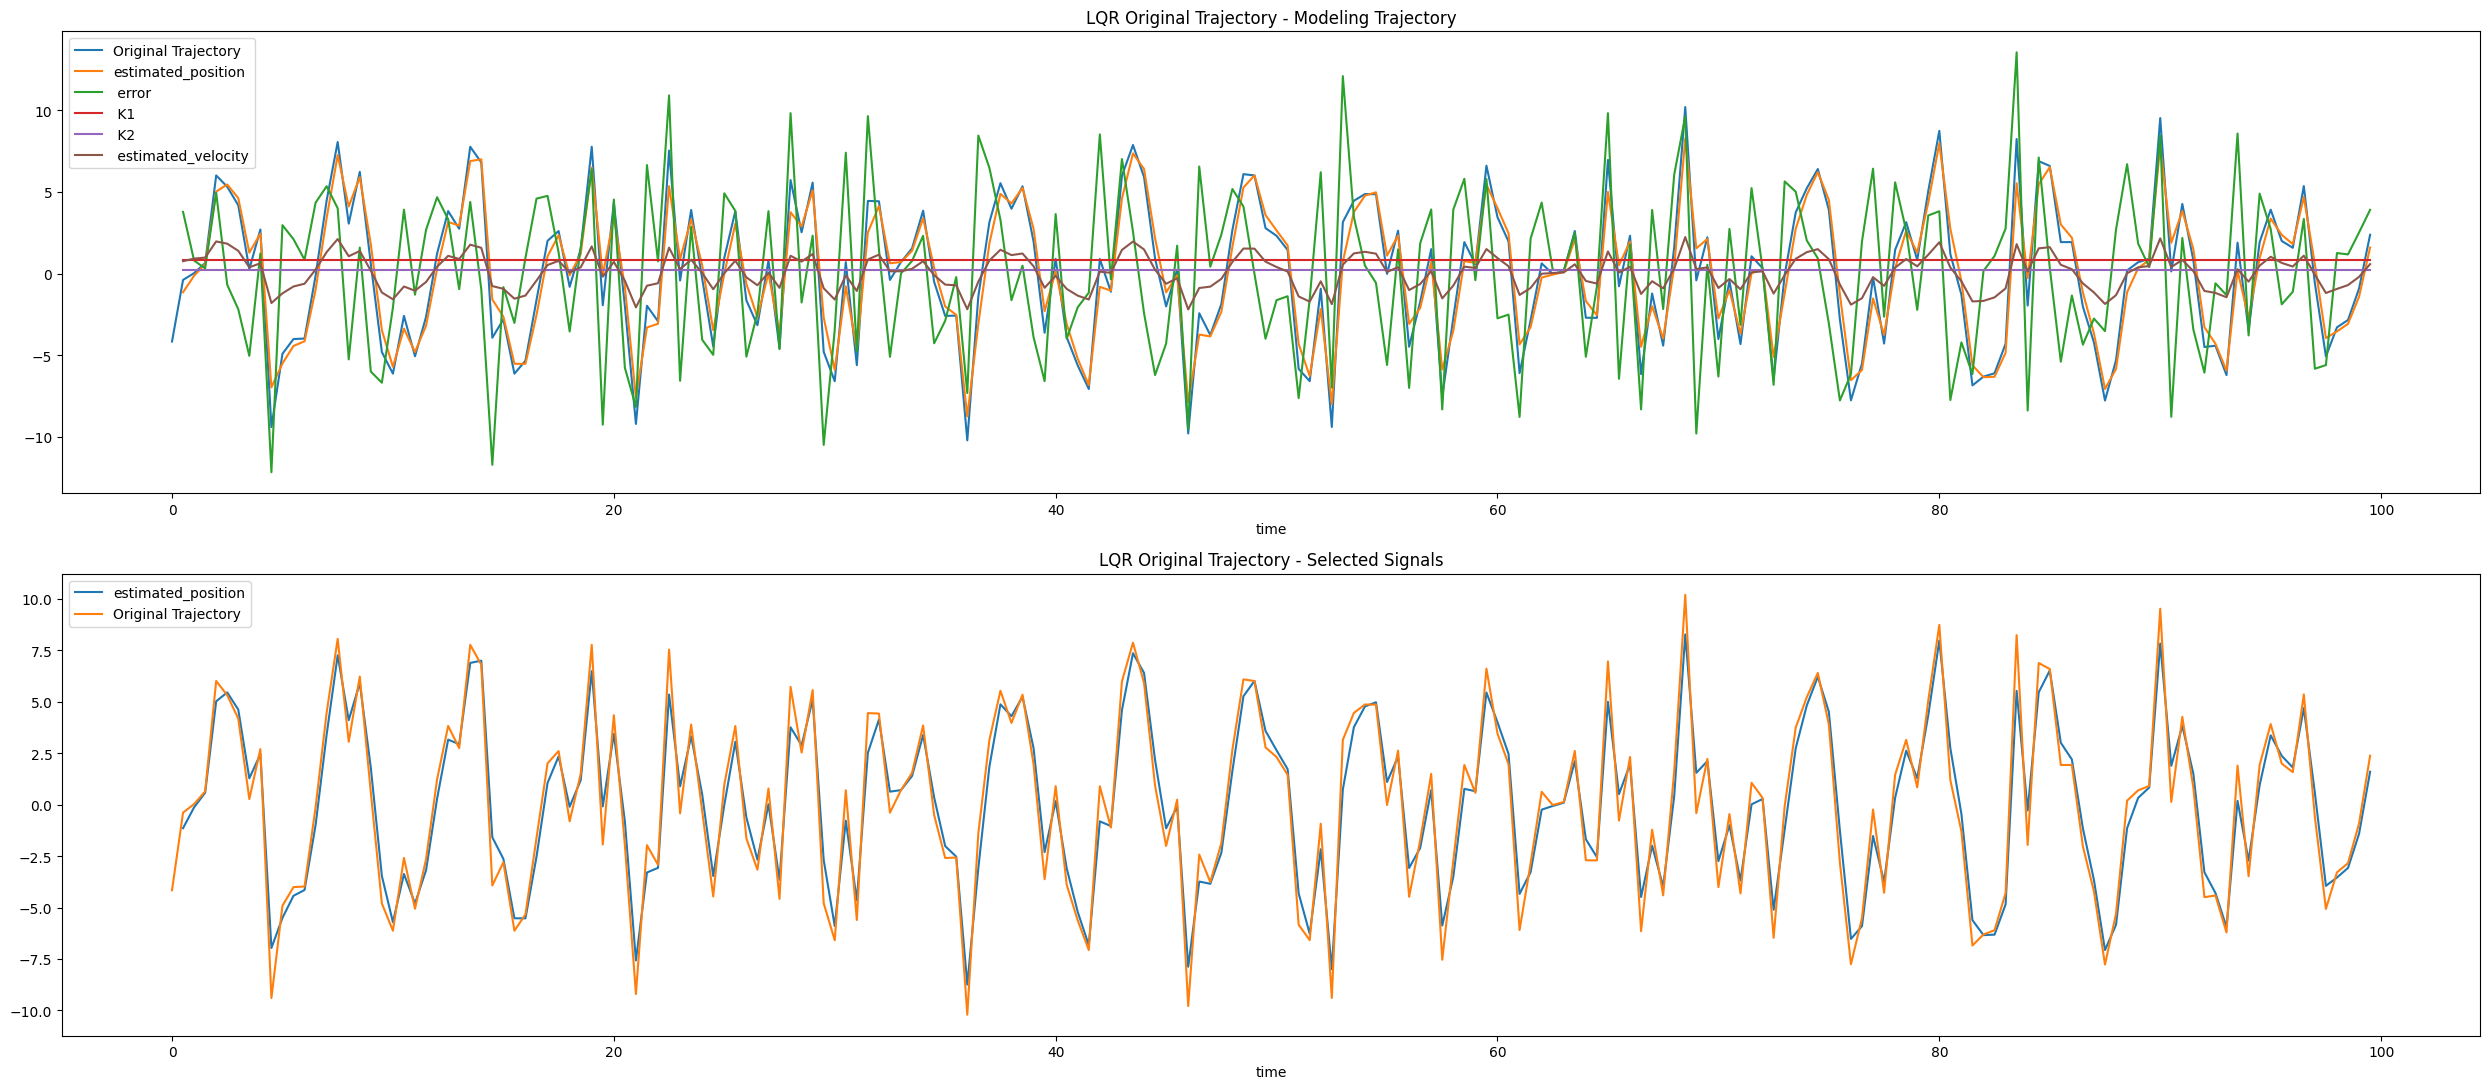

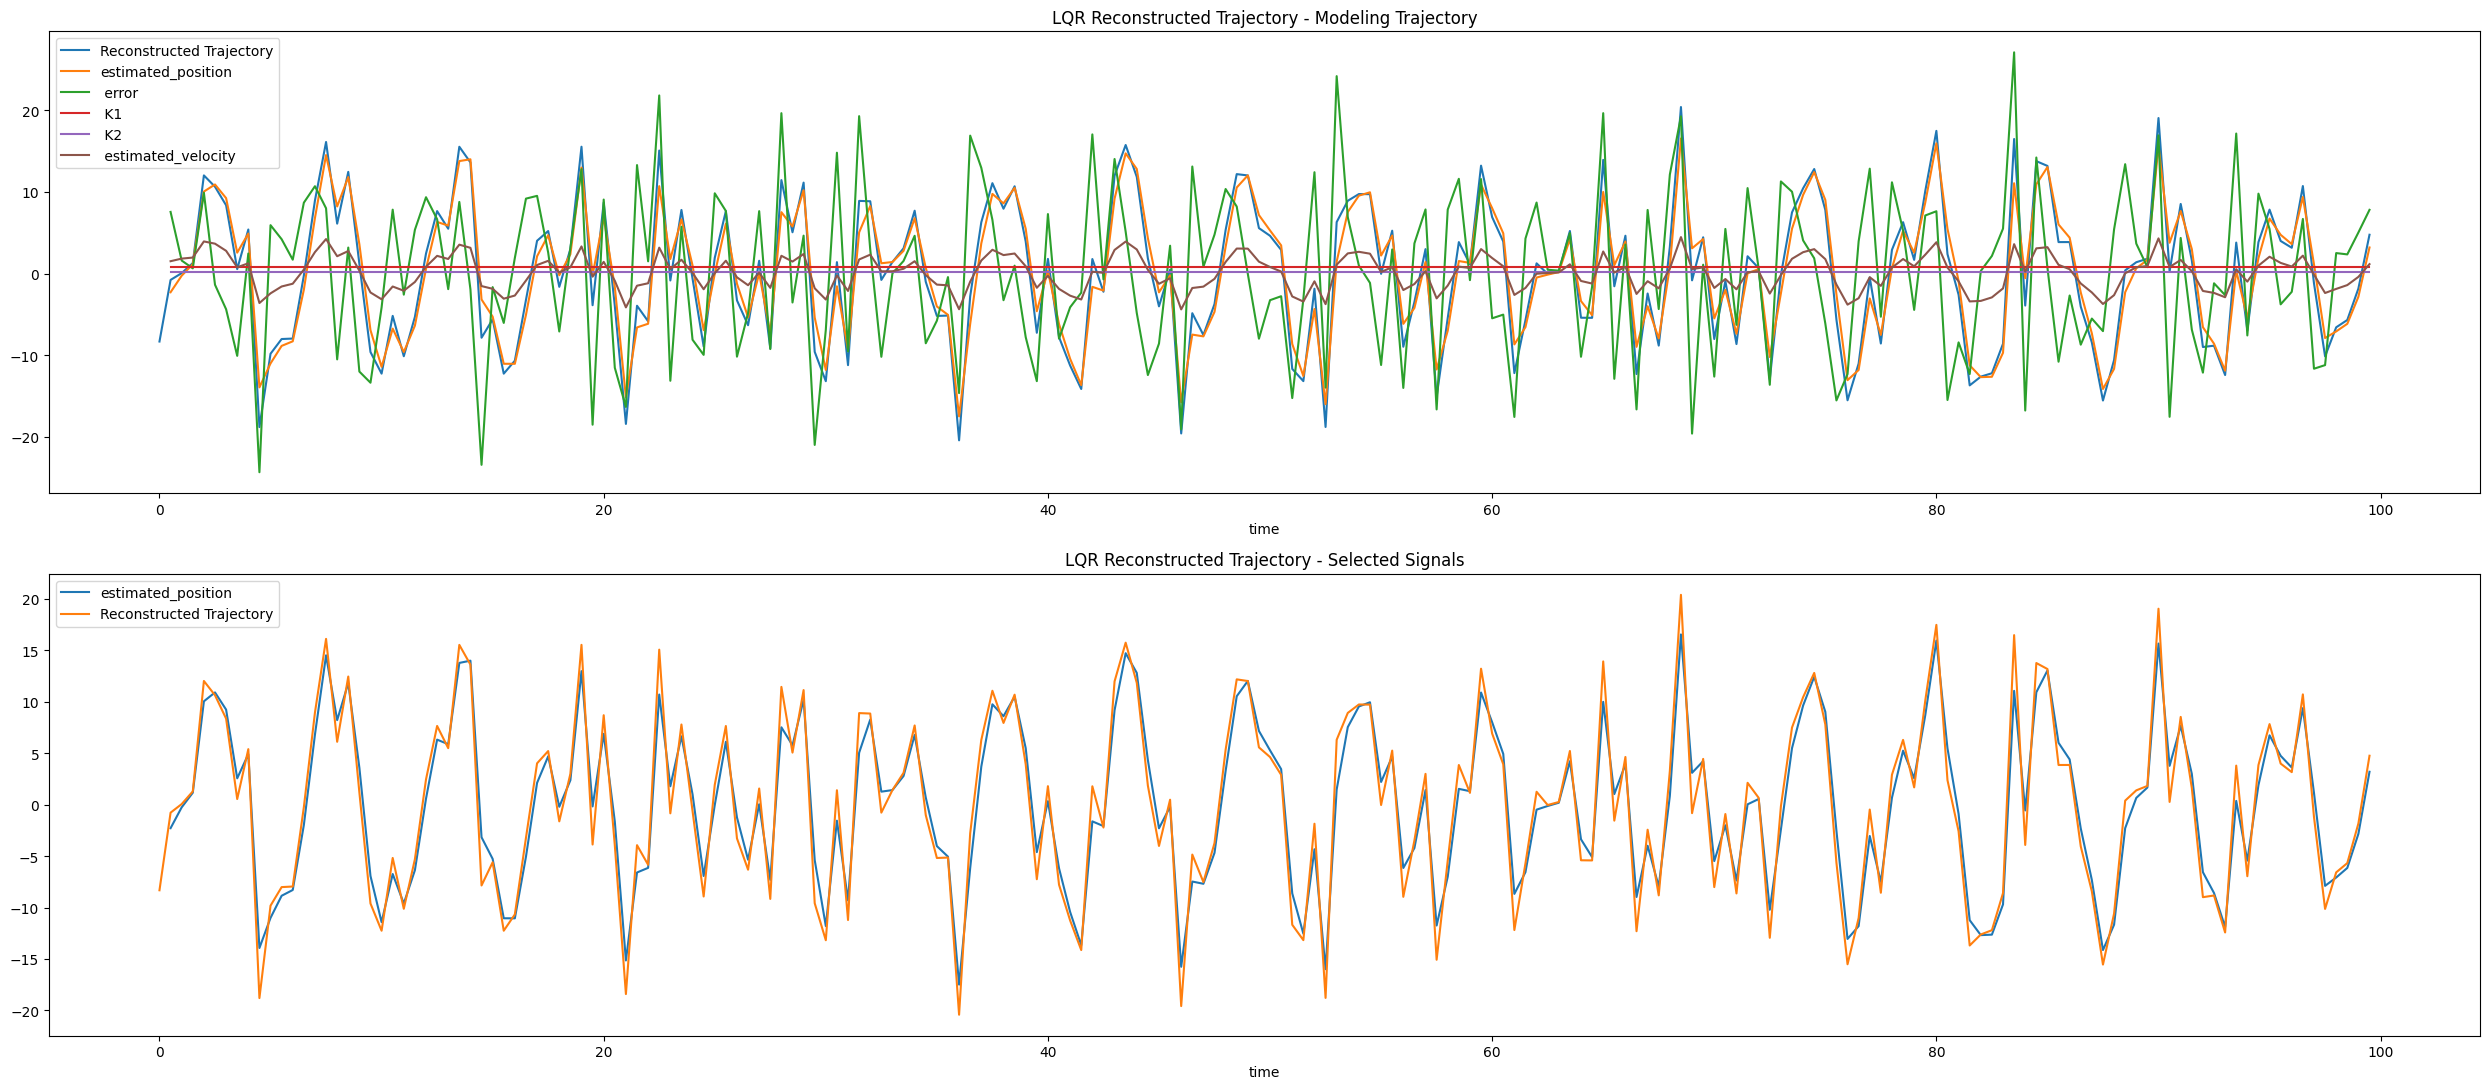

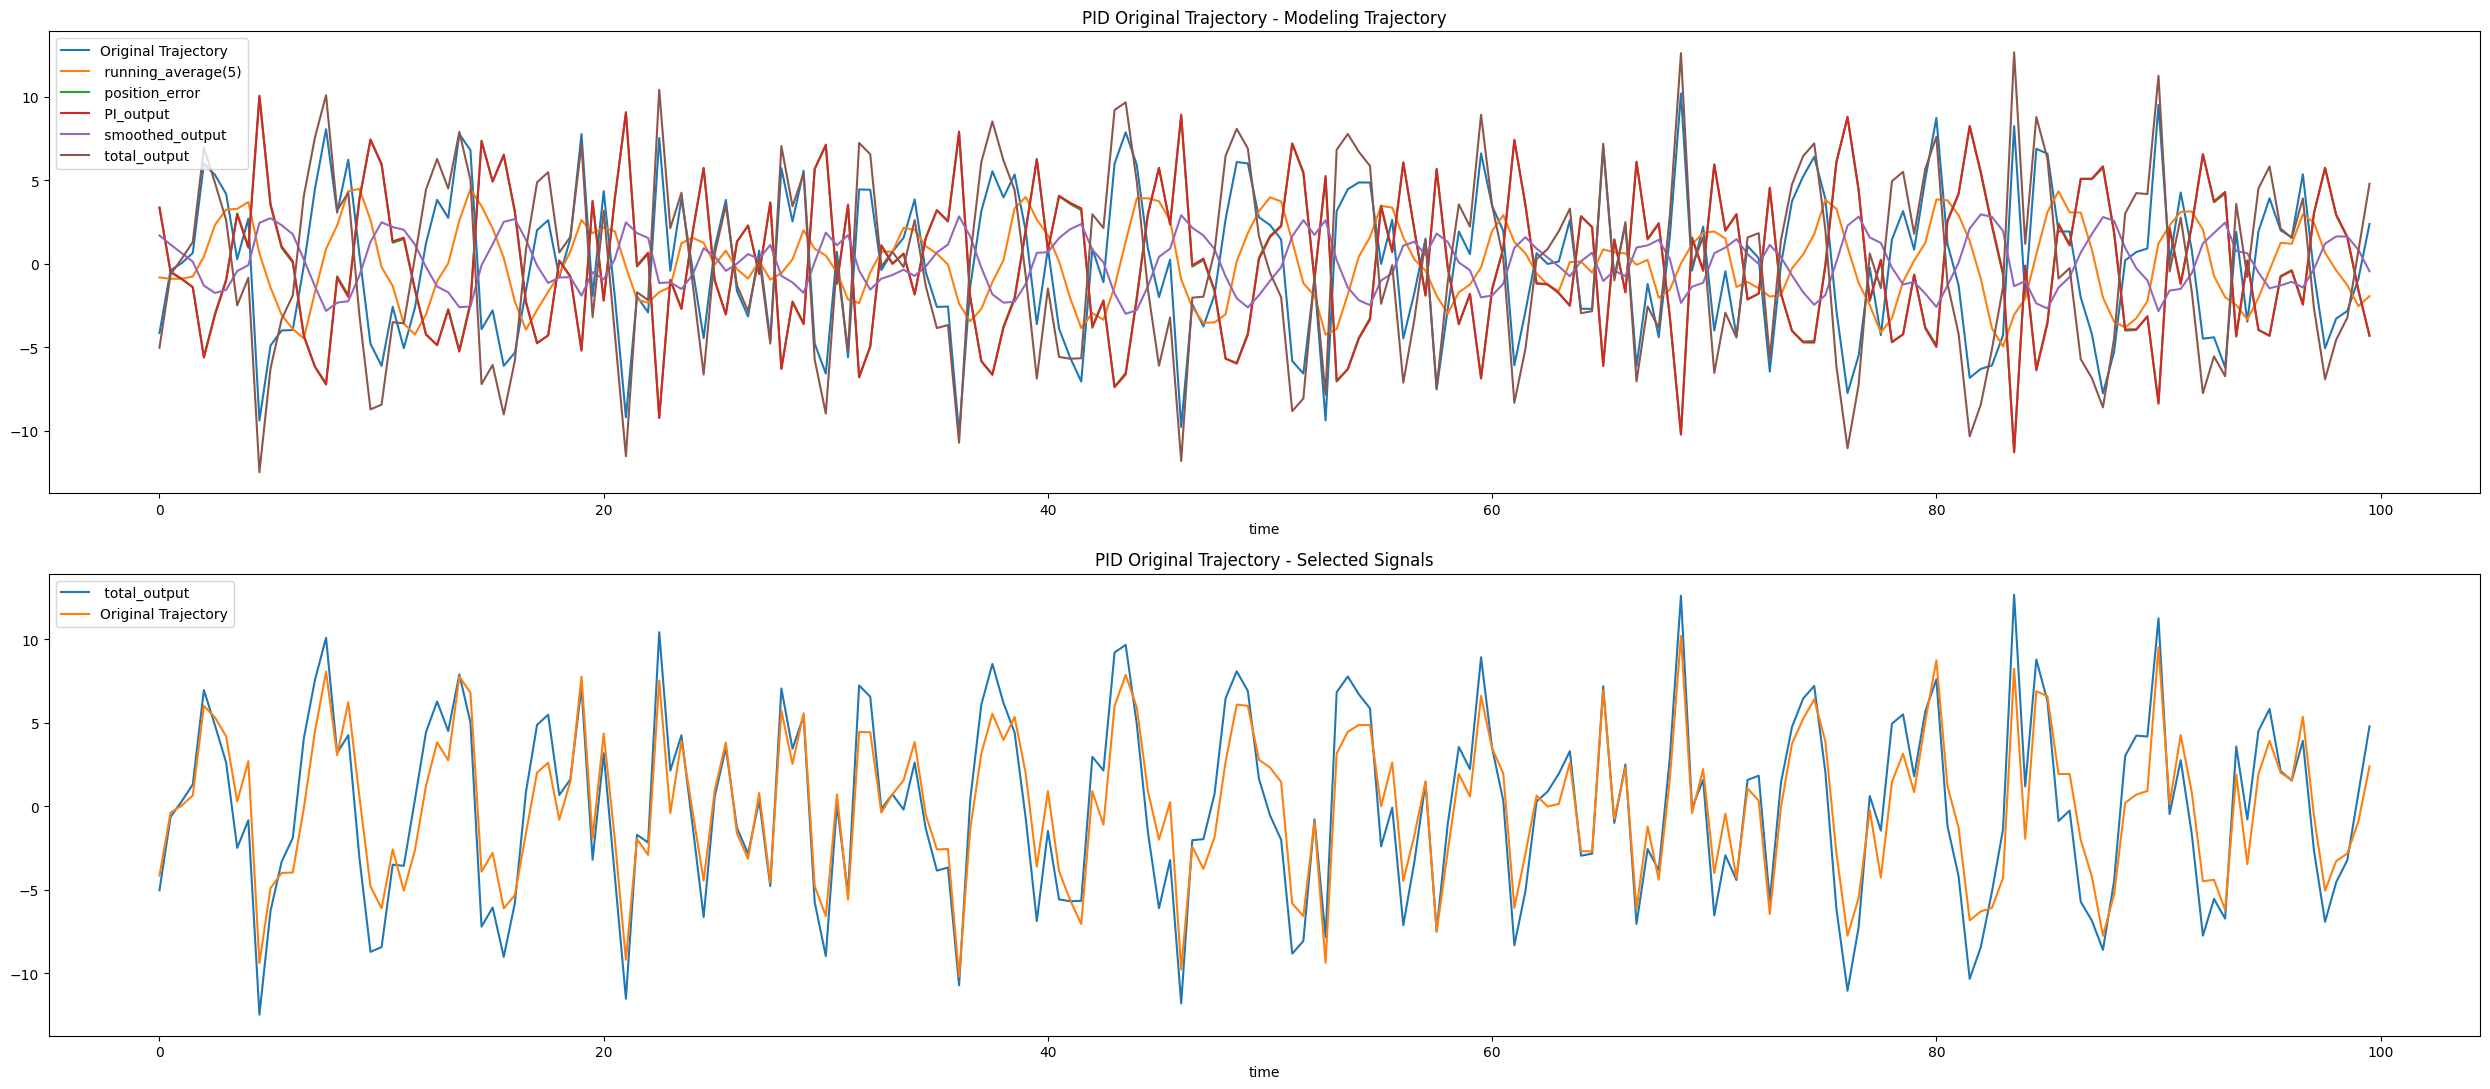

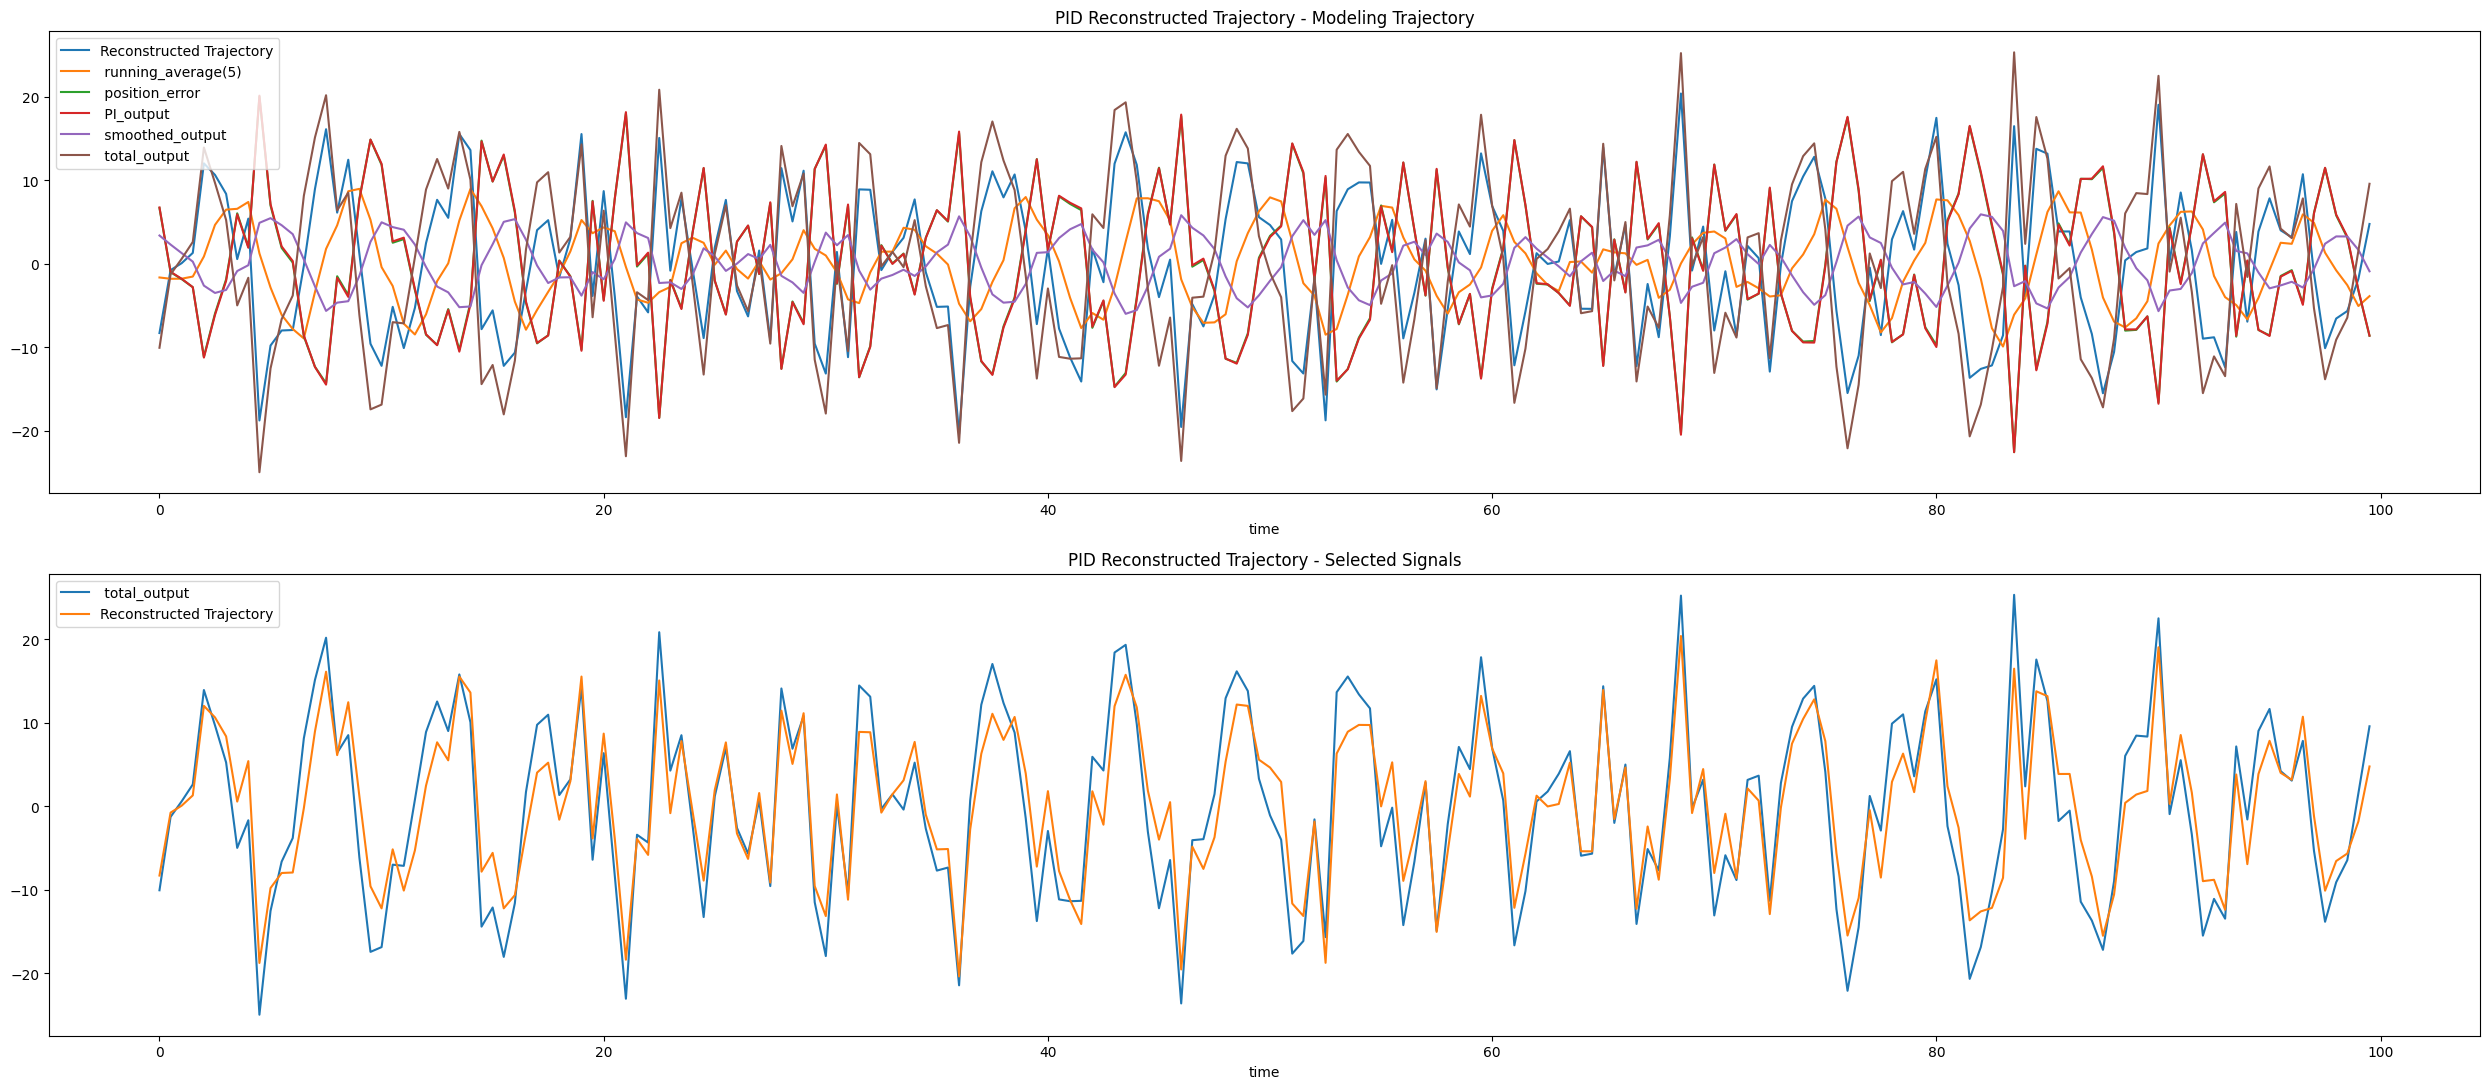

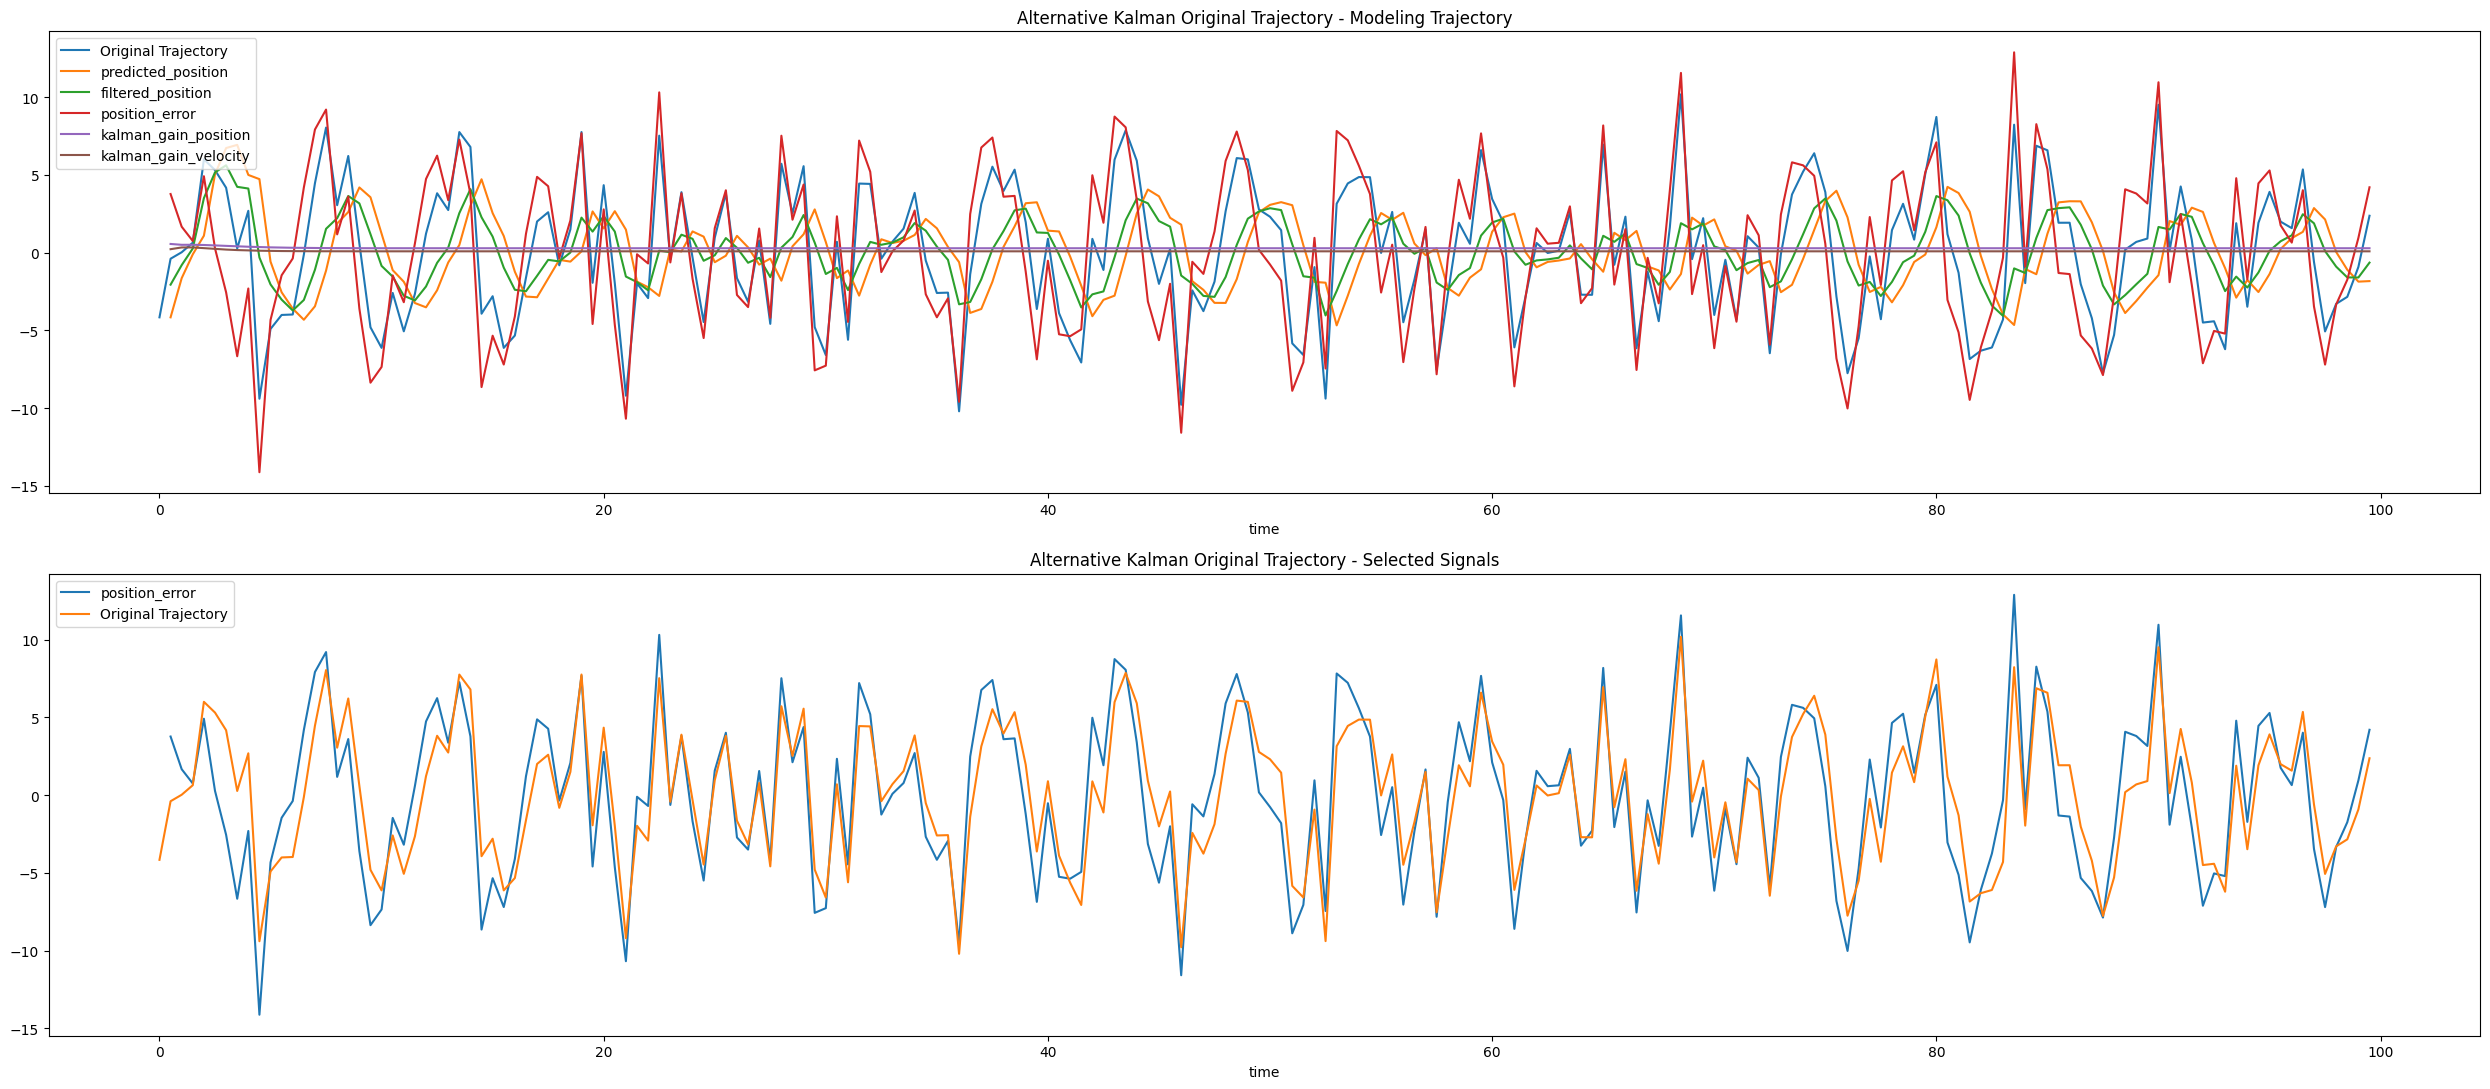

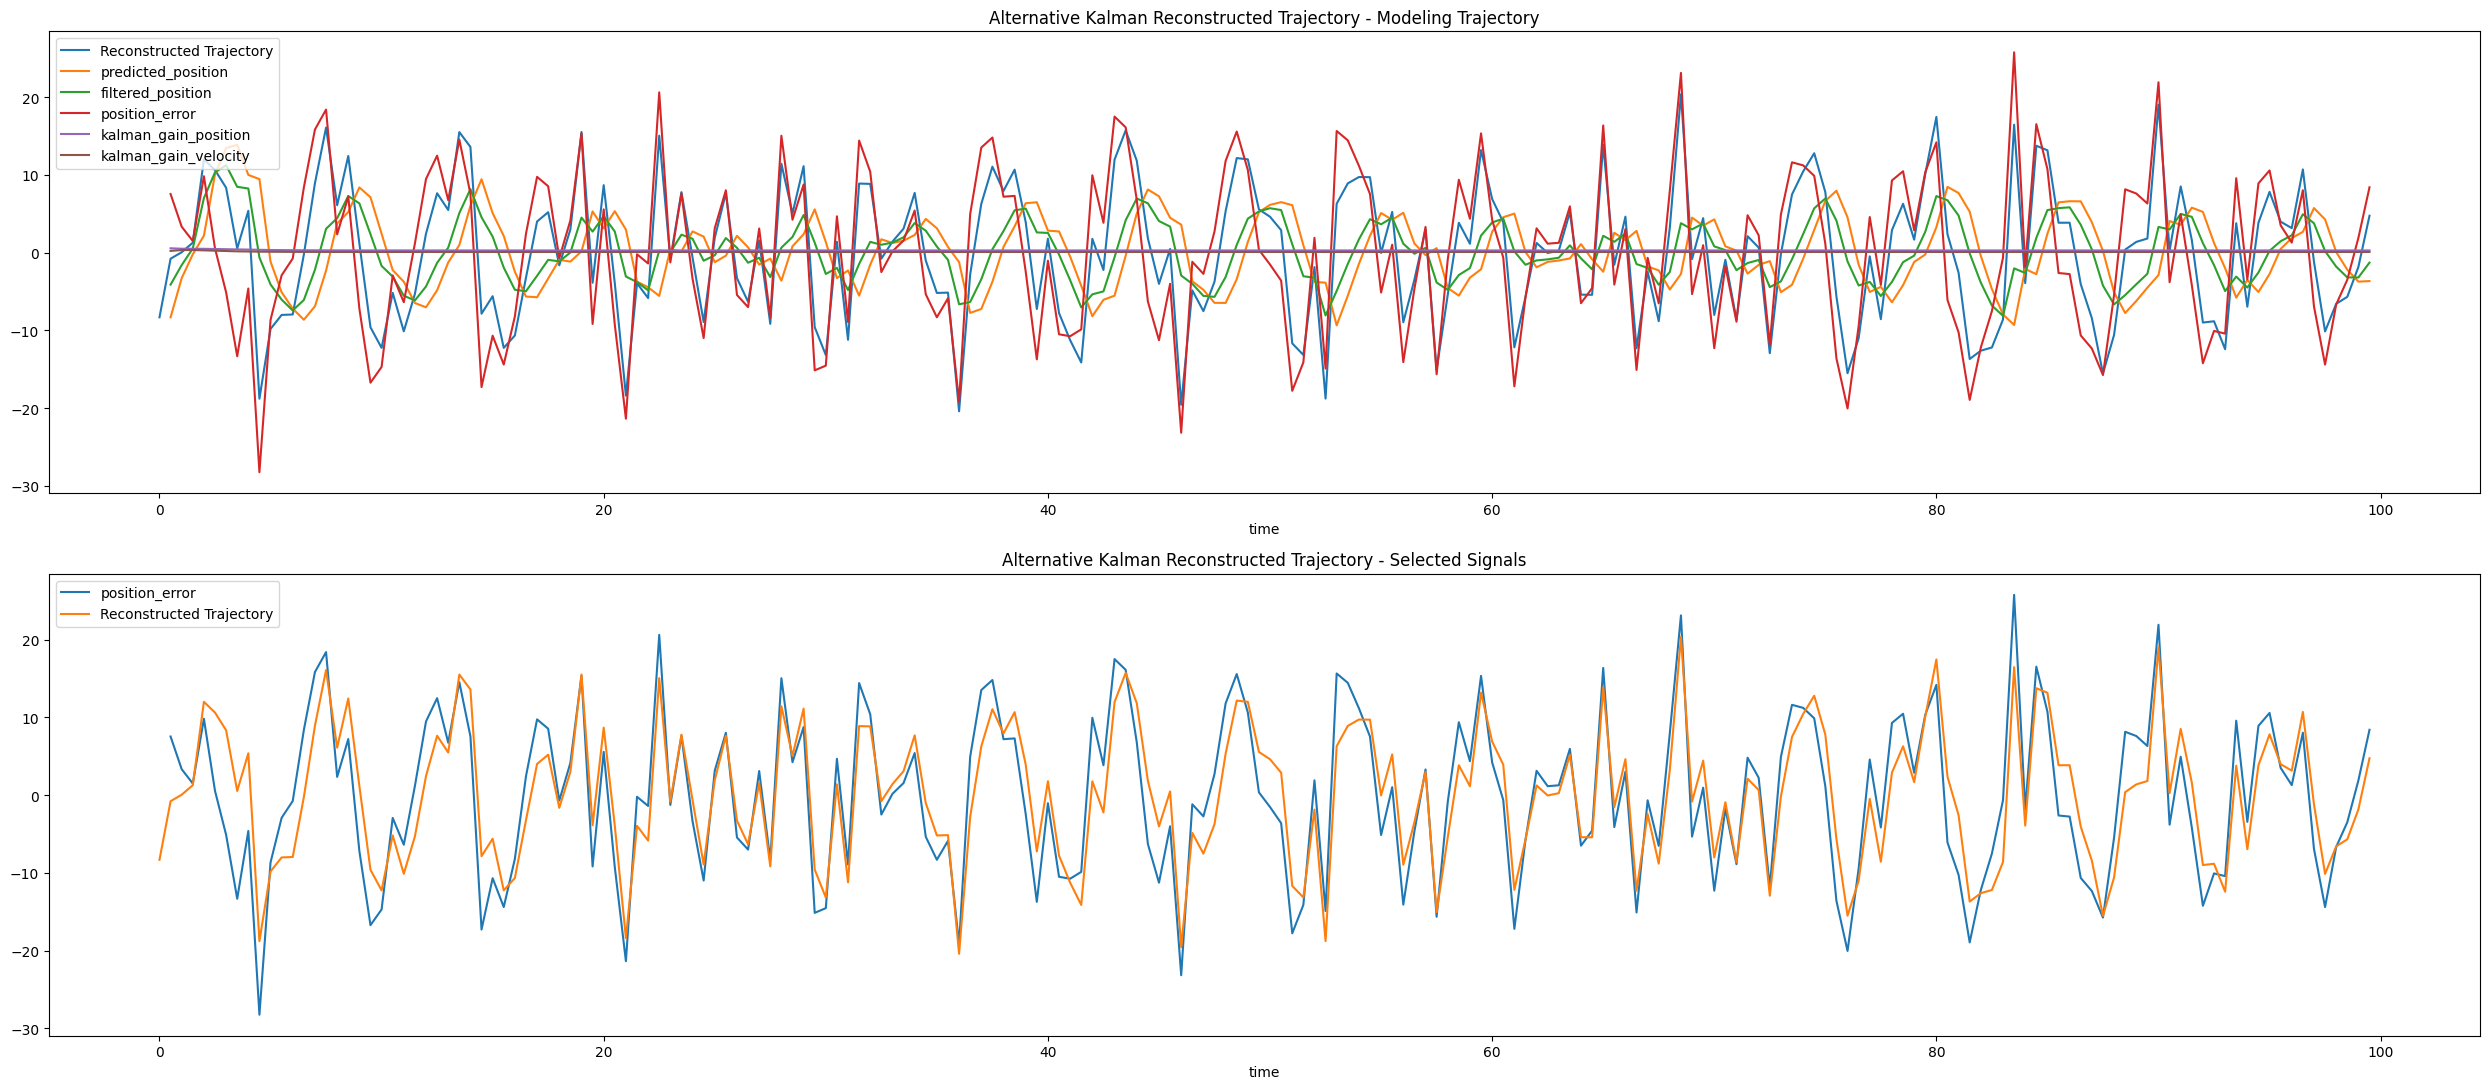

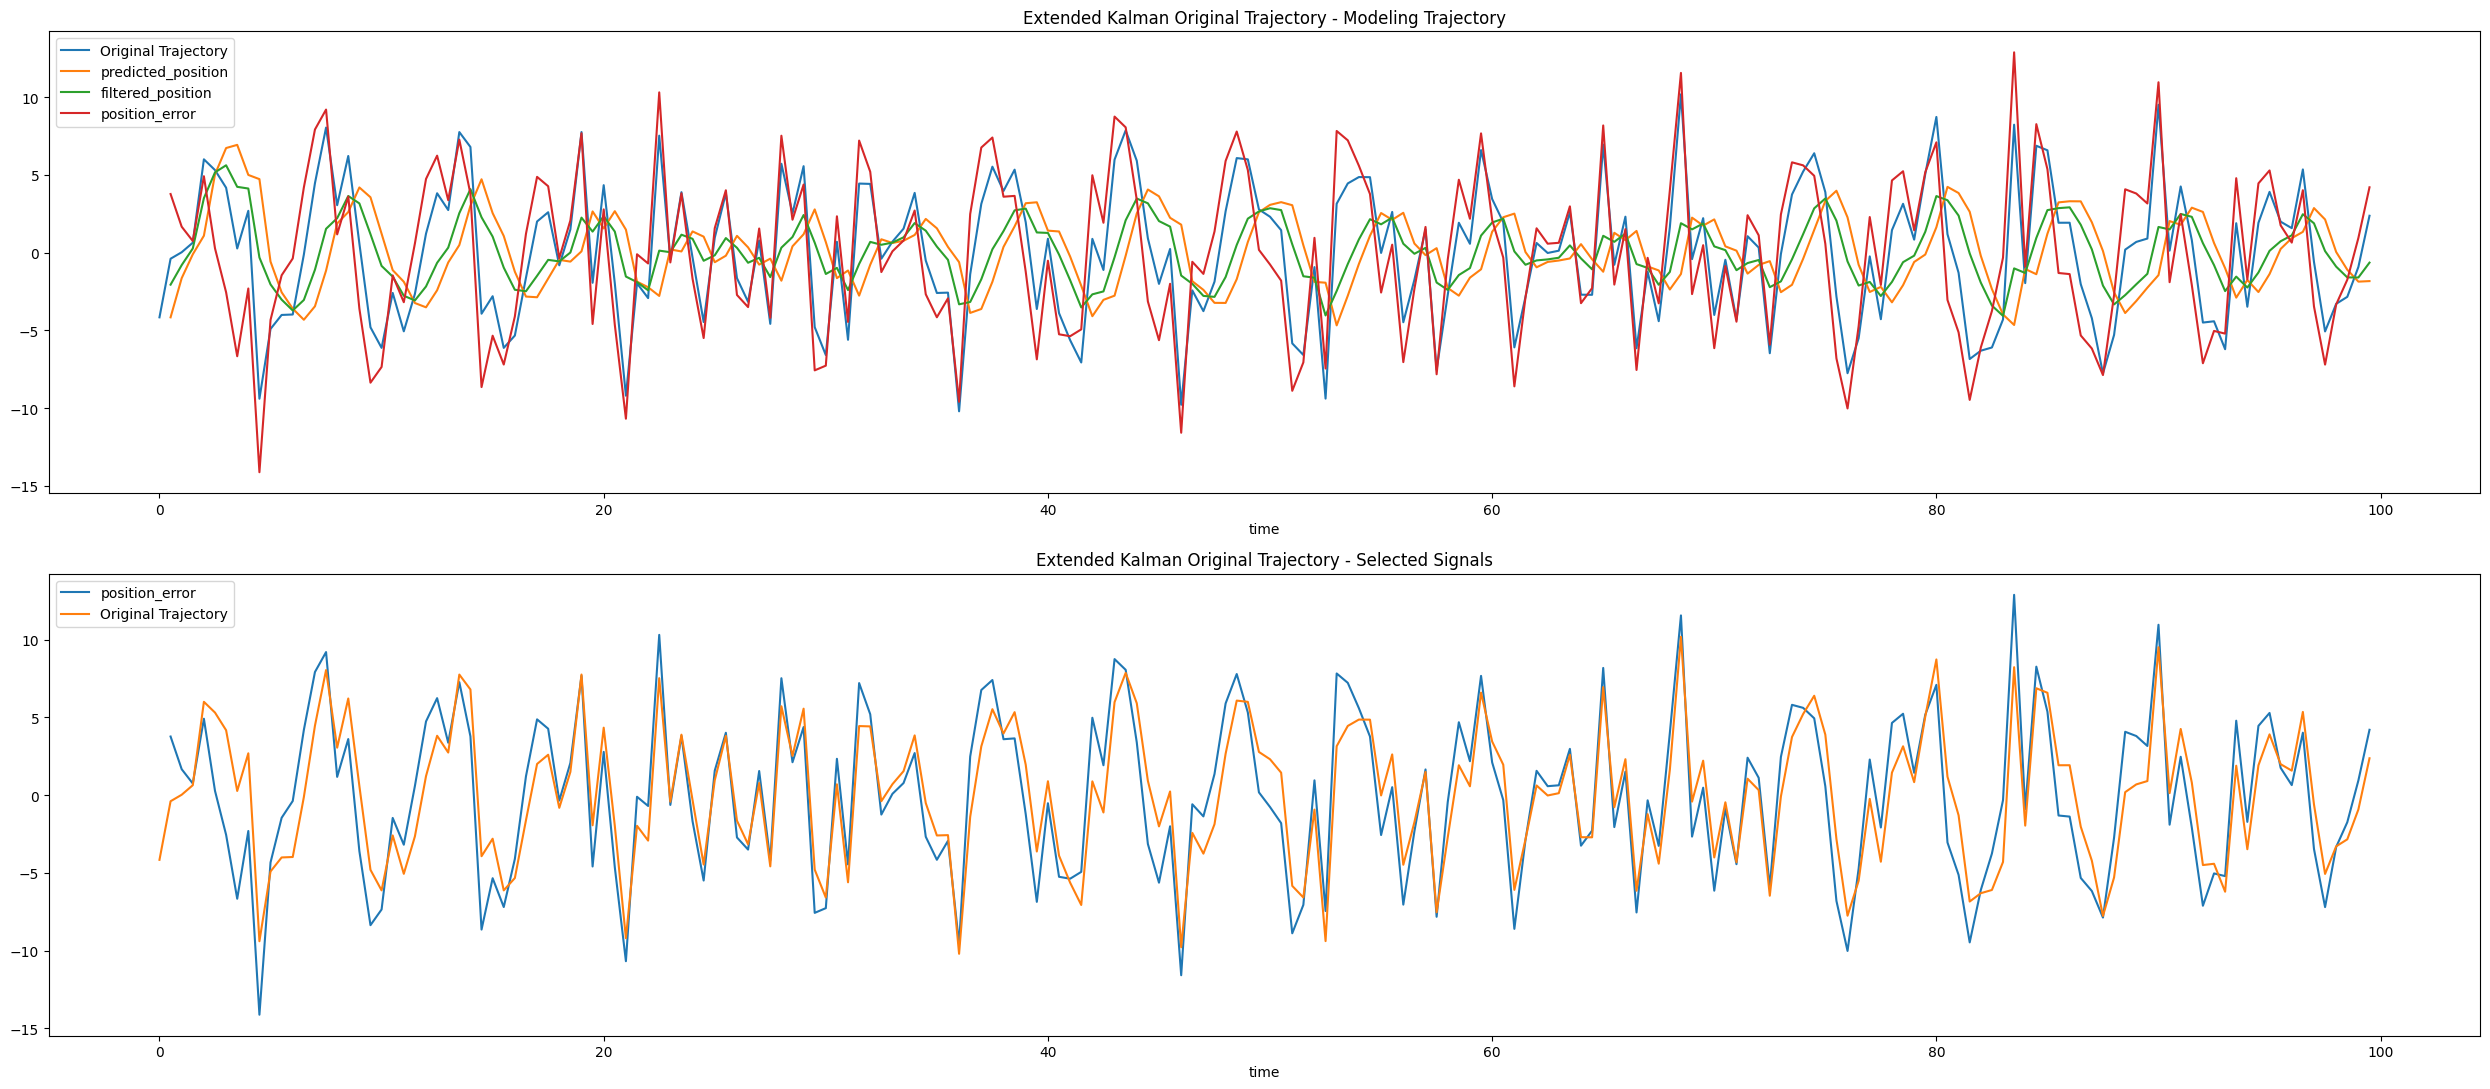

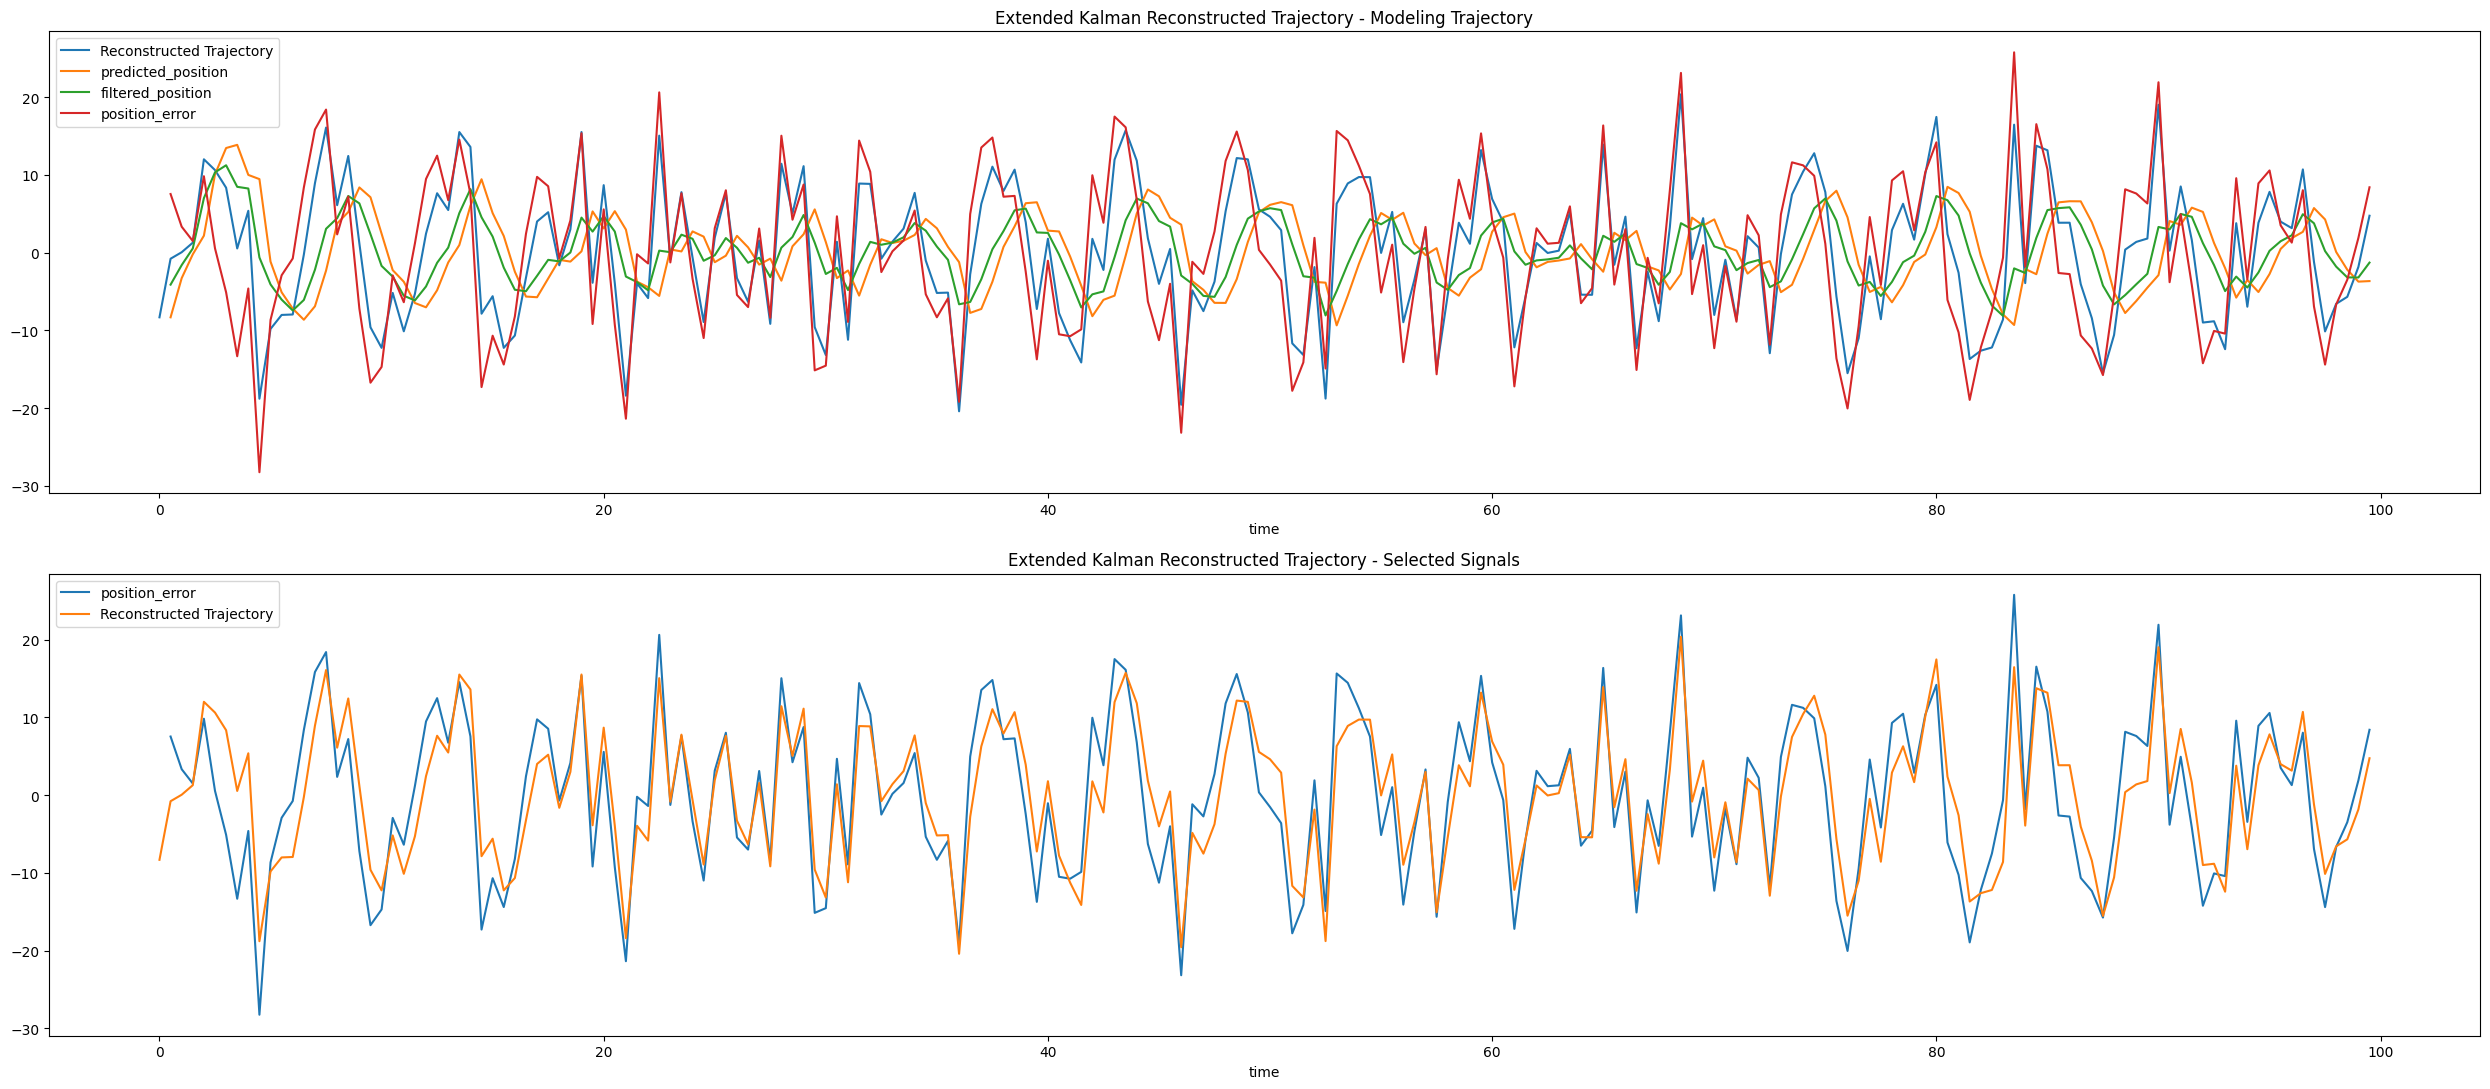

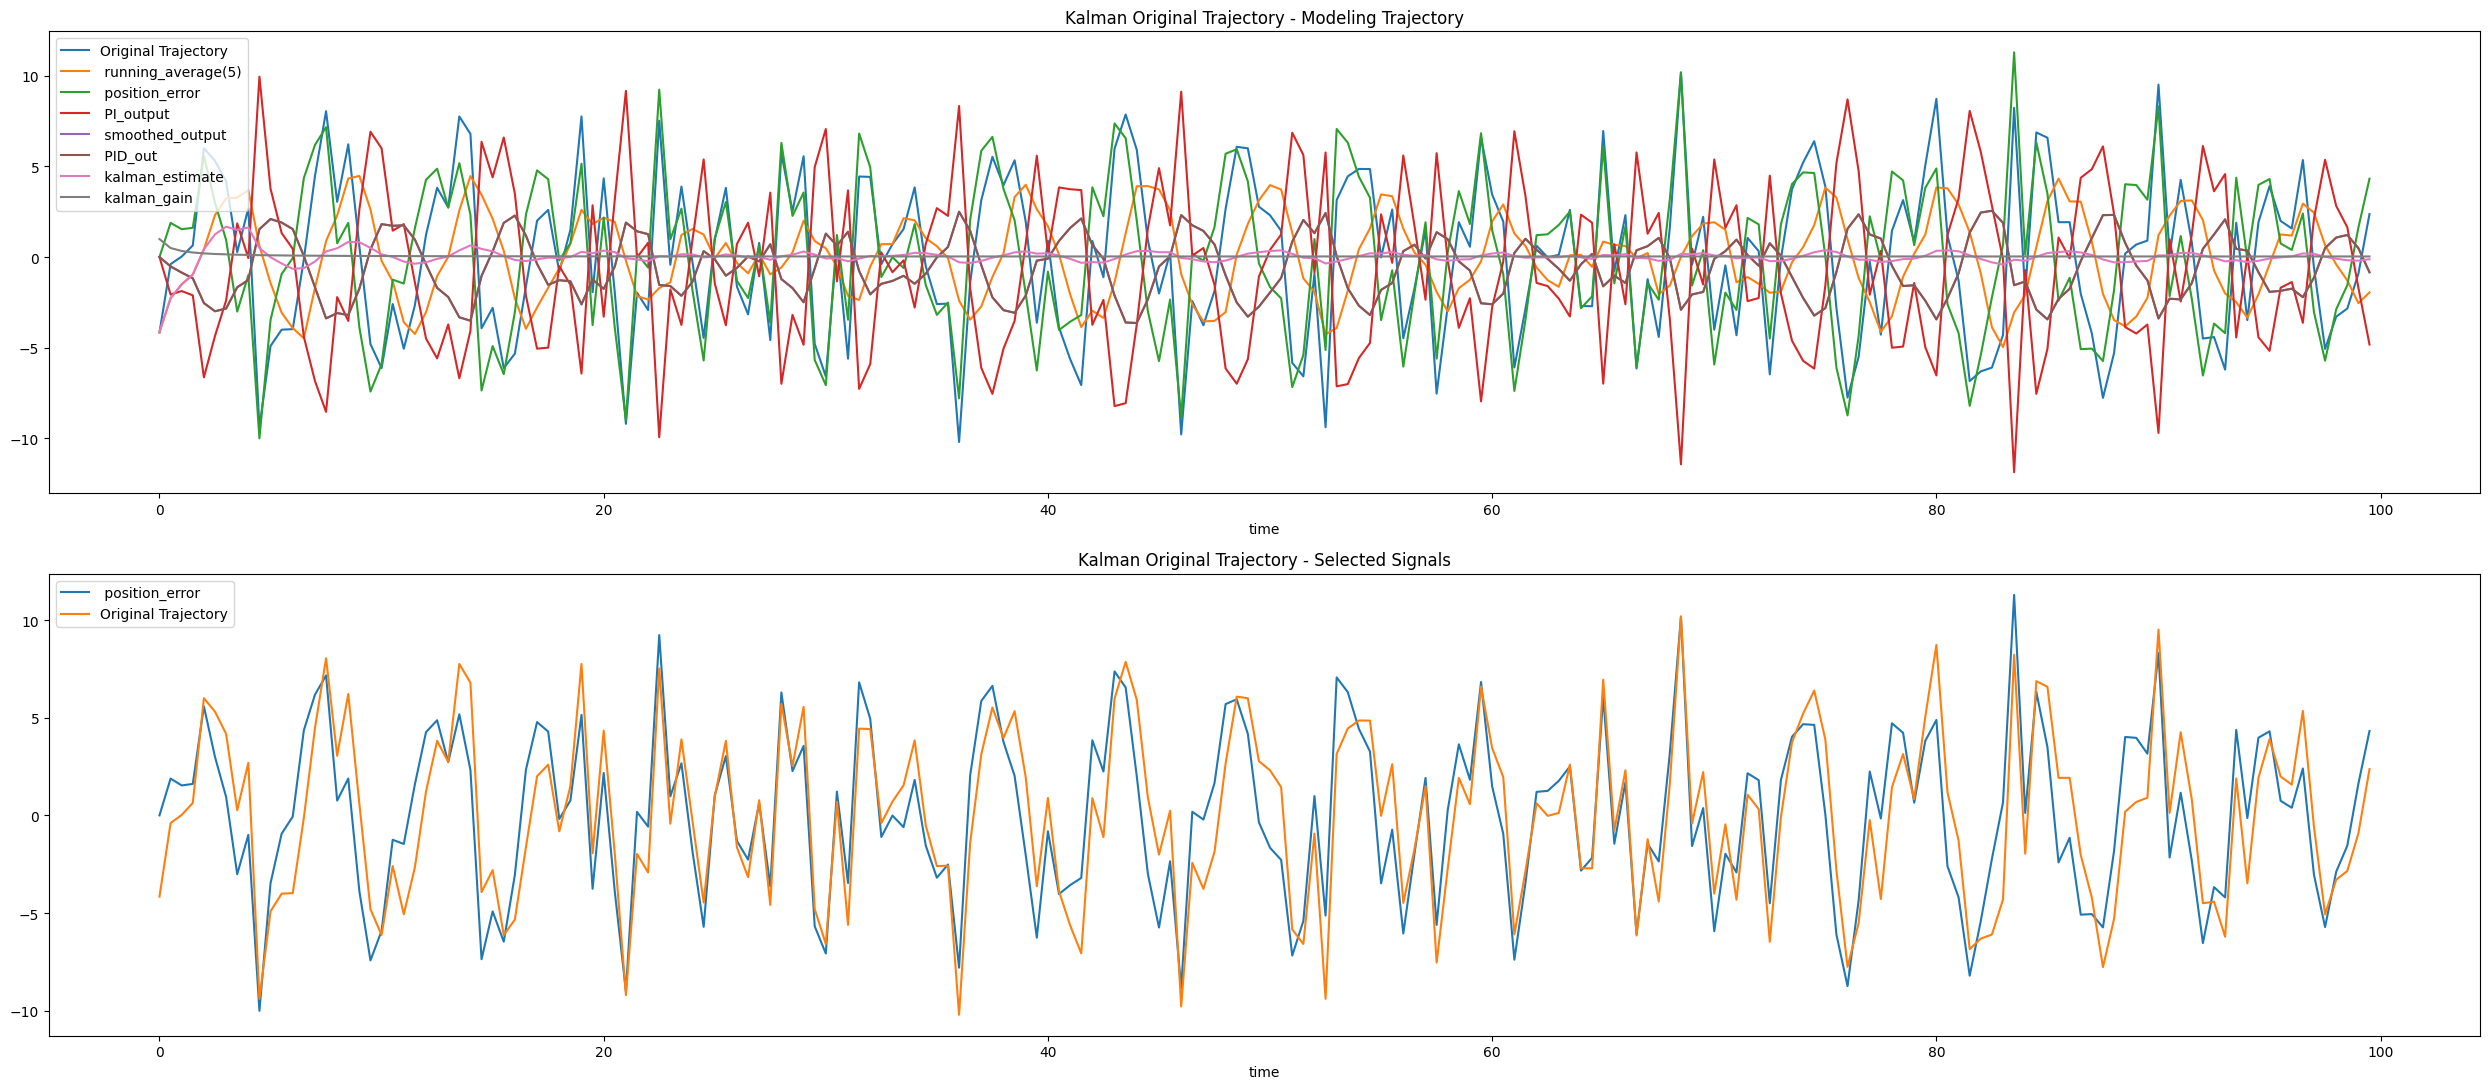

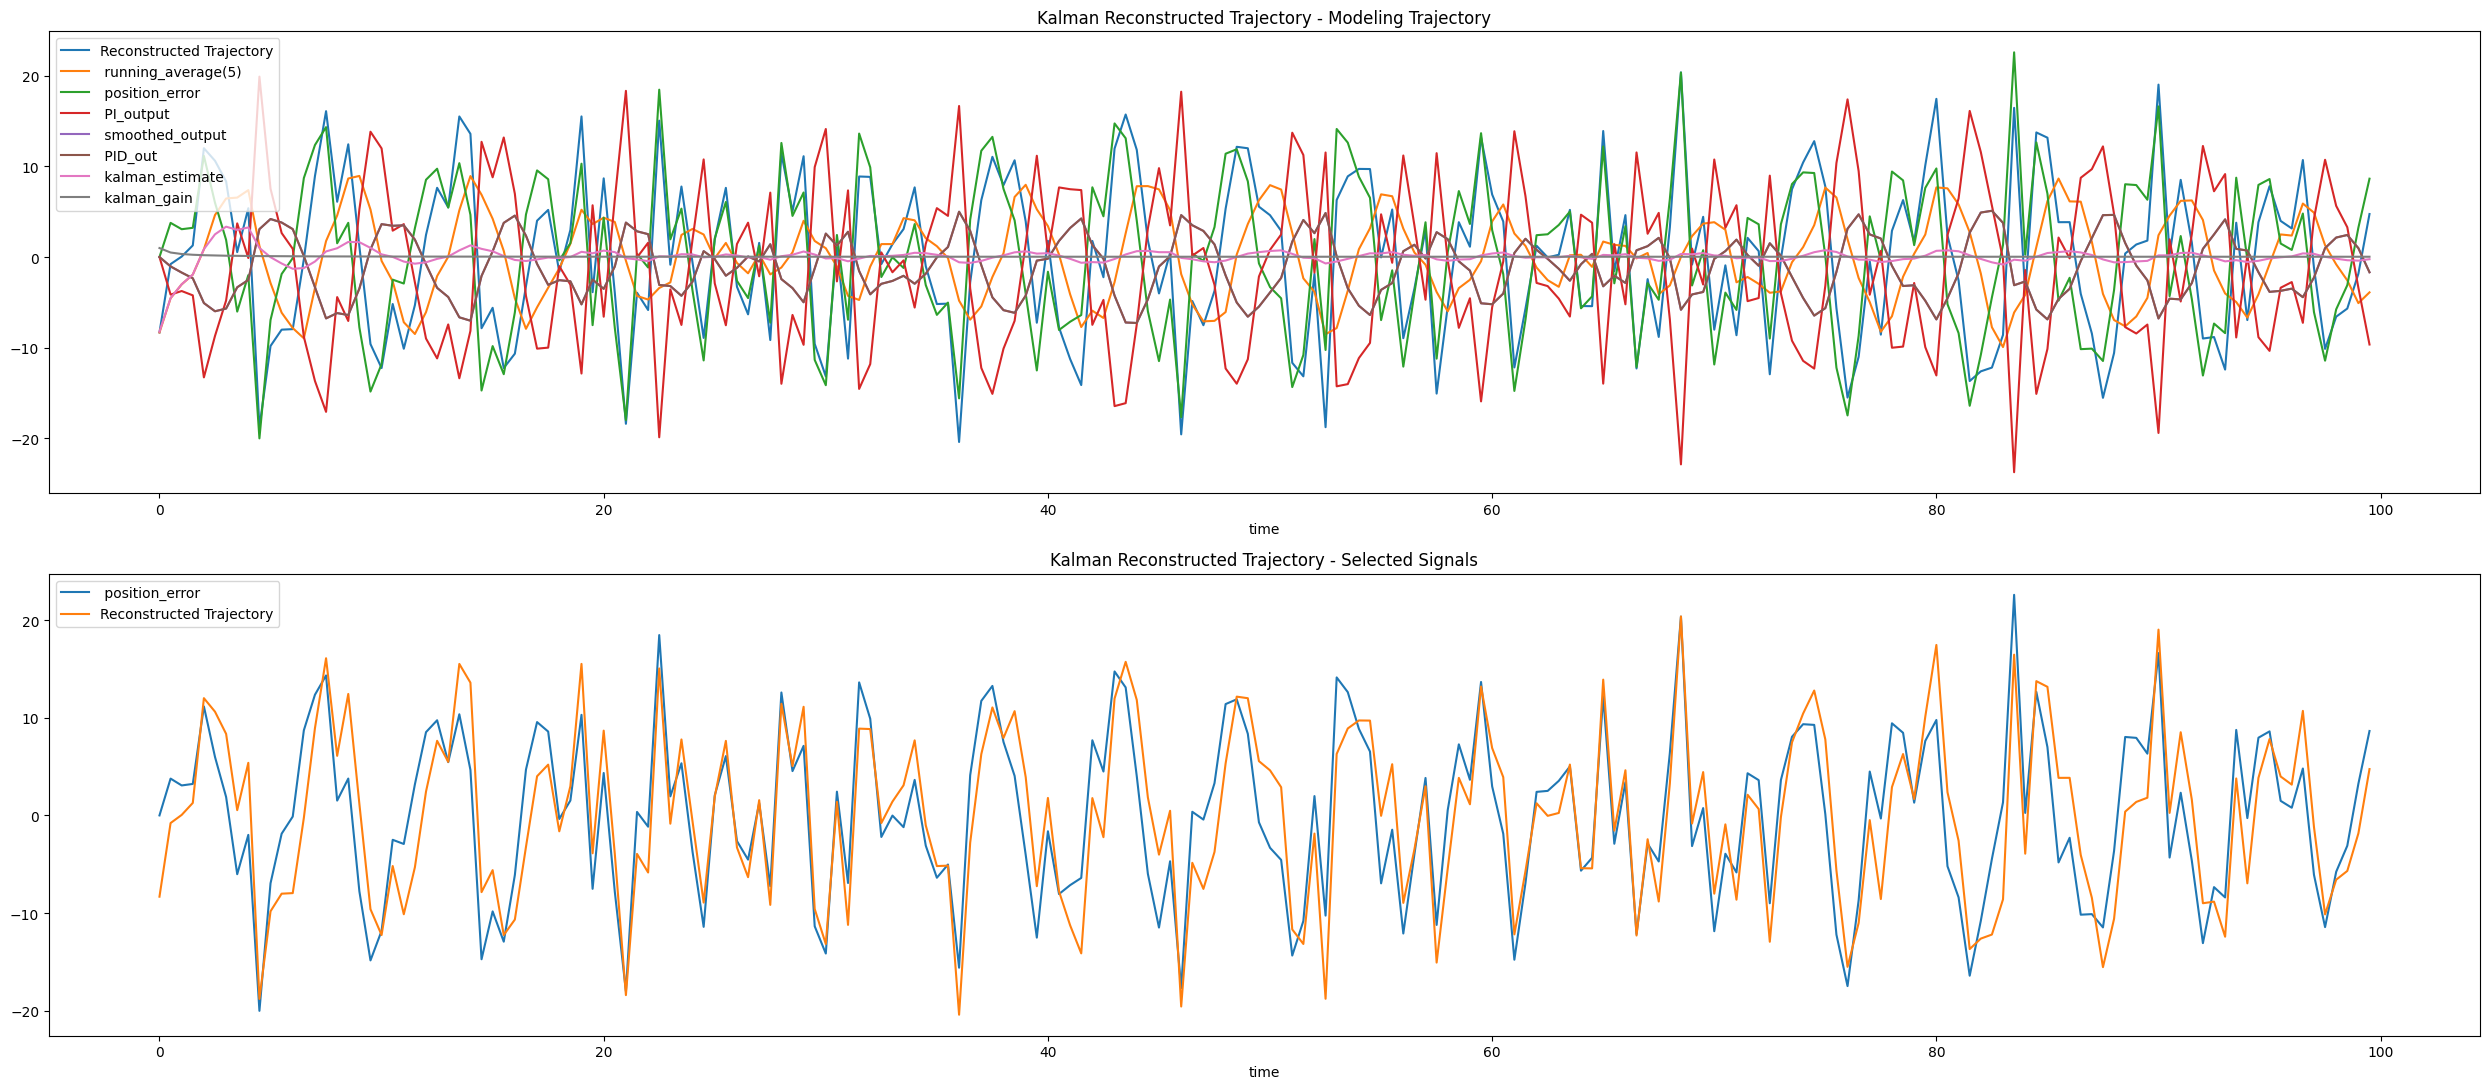

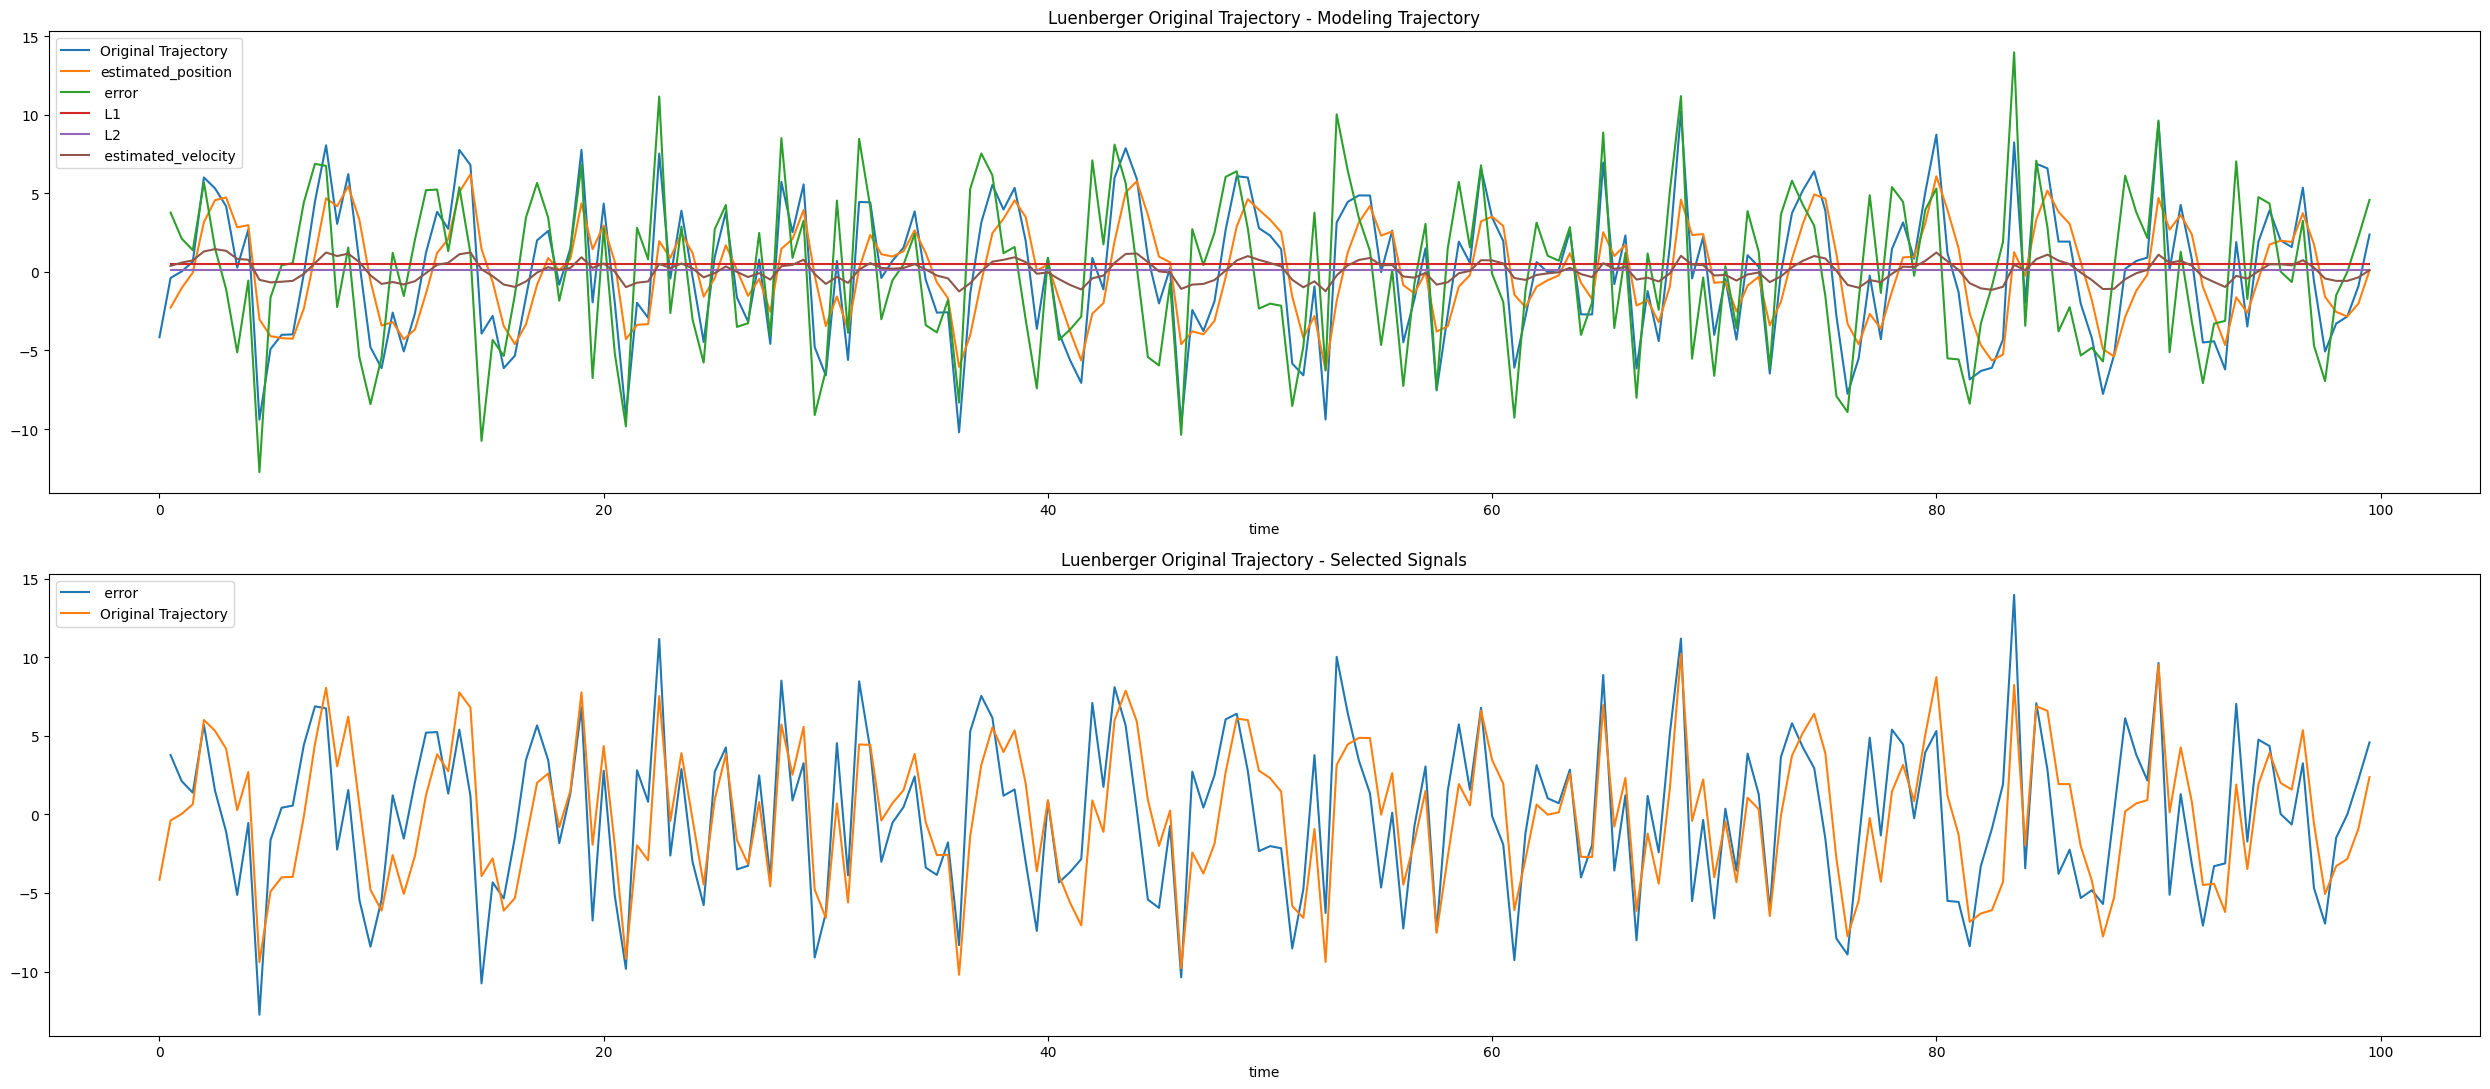

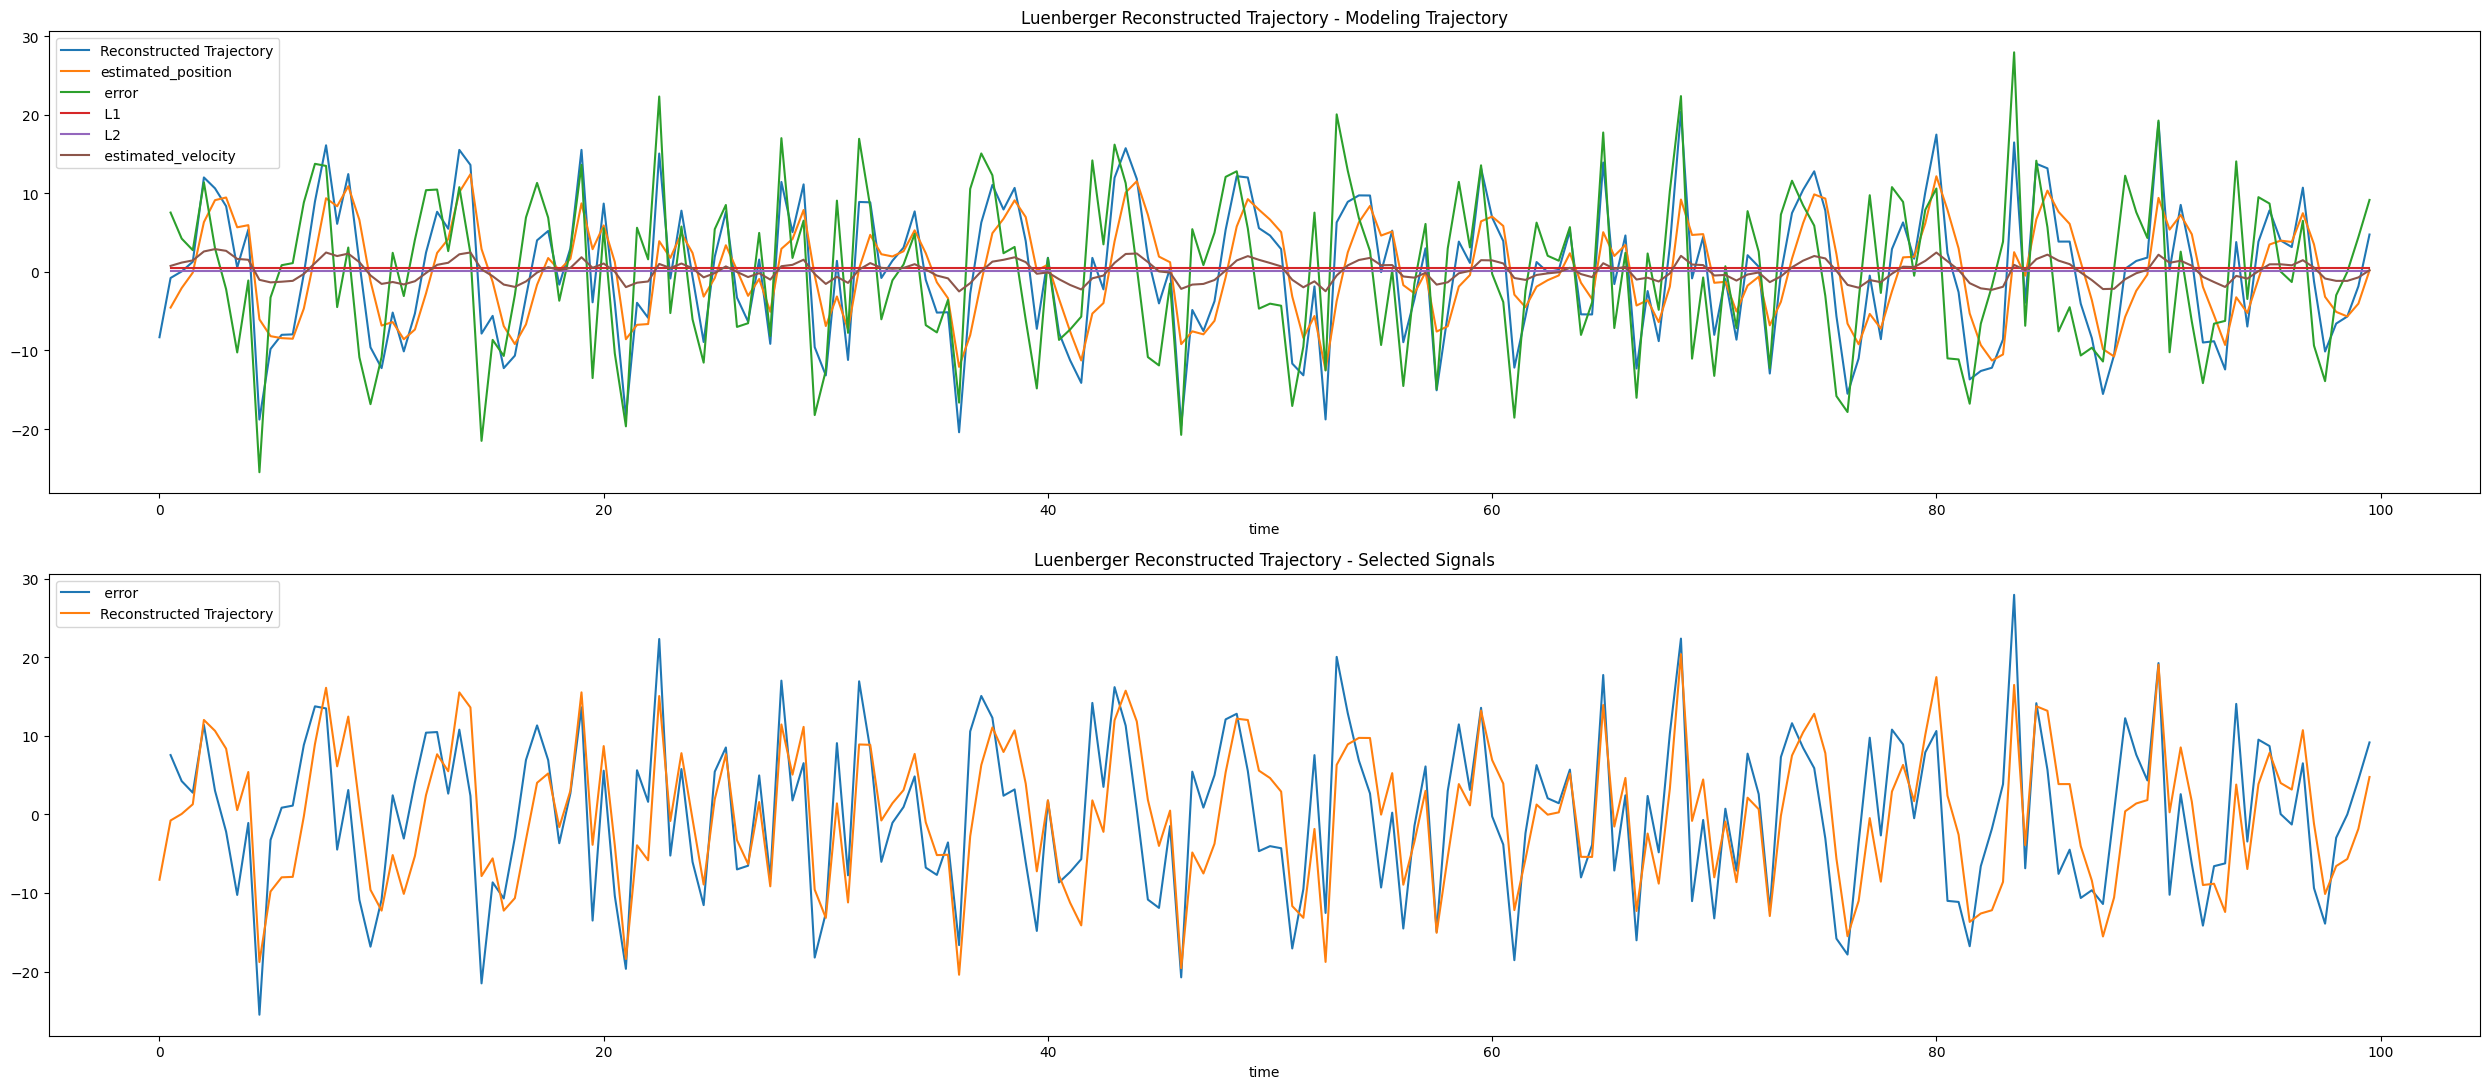

In [239]:
for file in sorted(csv_file):
    if file.endswith("_component.csv") or file.endswith("_position.csv"):
        continue

    df = pd.read_csv(file)
    headers = list(df.columns)[1:]

    has_measured = "measured_position" in headers
    if has_measured:
        headers.remove("measured_position")
    
    # Title formatting
    terms = file.split(".")[0].split("_")
    title = " ".join(terms)
    last_char = title[-1]
    title = title[:-1]
    if not (title == 'PID' or title == 'LQR'):
        title = title.title()

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(figsize=(25, 11), ncols=1, nrows=2)

    # Subplot 1: Full trajectory and model estimates
    if last_char == "1":
        ax1.plot(trajectory["time"], trajectory["position"], label="Original Trajectory")
        title += " Original Trajectory"
    elif last_char == "2":
        ax1.plot(inverted_trajectory["time"], inverted_trajectory["position"], label="Reconstructed Trajectory")
        title += " Reconstructed Trajectory"

    for header in headers:
        ax1.plot(df["time"], df[header], label=header)

    ax1.set_xlabel("time")
    ax1.set_title(title + " - Modeling Trajectory")
    ax1.legend(loc="upper left")

    # Subplot 2: Selected signal(s)
    selected_headers = []
    if "PID" in title:
        selected_headers = [col for col in df.columns if "total_output" in col]
    elif "Kalman" in title:
        selected_headers = [col for col in df.columns if "error" in col]
    elif "LQR" in title:
        selected_headers = [col for col in df.columns if any(k in col for k in ["estimated_position"])]
    elif "Luenberger" in title:
        selected_headers = [col for col in df.columns if any(k in col for k in ["error"])]

    for header in selected_headers:
        ax2.plot(df["time"], df[header], label=header)

    if last_char == "1":
        ax2.plot(trajectory["time"], trajectory["position"], label="Original Trajectory")
    elif last_char == "2":
        ax2.plot(inverted_trajectory["time"], inverted_trajectory["position"], label="Reconstructed Trajectory")

    ax2.set_xlabel("time")
    ax2.set_title(title + " - Selected Signals")
    ax2.legend(loc="upper left")

    # Layout and show
    plt.tight_layout()
    plt.show()
